# Perform Analysis - Using out of the box tools

There are many out-of-the-box raster analysis tools available in ArcGIS API for Python. In this guide, we will demonstrate a few examples such as creating viewshed, interpolating points, converting raster to feature, and converting feature to raster.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-prepared" data-toc-modified-id="Getting-prepared-1">Getting prepared</a></span></li><li><span><a href="#Creating-viewshed" data-toc-modified-id="Creating-viewshed-2">Creating viewshed</a></span></li><li><span><a href="#Interpolating-points" data-toc-modified-id="Interpolating-points-3">Interpolating points</a></span></li><li><span><a href="#Converting-feature-to-raster" data-toc-modified-id="Converting-feature-to-raster-4">Converting feature to raster</a></span></li><li><span><a href="#Converting-raster-to-feature" data-toc-modified-id="Converting-raster-to-feature-5">Converting raster to feature</a></span></li></ul></div>

## Getting prepared

Let's first import the packages and make a connection to our GIS.

In [2]:
import arcgis
from arcgis.gis import GIS

gis = GIS(url='https://pythonapi.playground.esri.com/portal', username='arcgis_python', password='amazing_arcgis_123')

## Creating viewshed

Viewshed indentifies the cells in an input raster that can be seen from one or more observation points or lines. Each cell in the output raster receives a value that indicates how many points or lines can be seen from each location. Viewshed is very useful when you want to know how visible objects might be, such as finding well-exposed places for communication towers.

<center>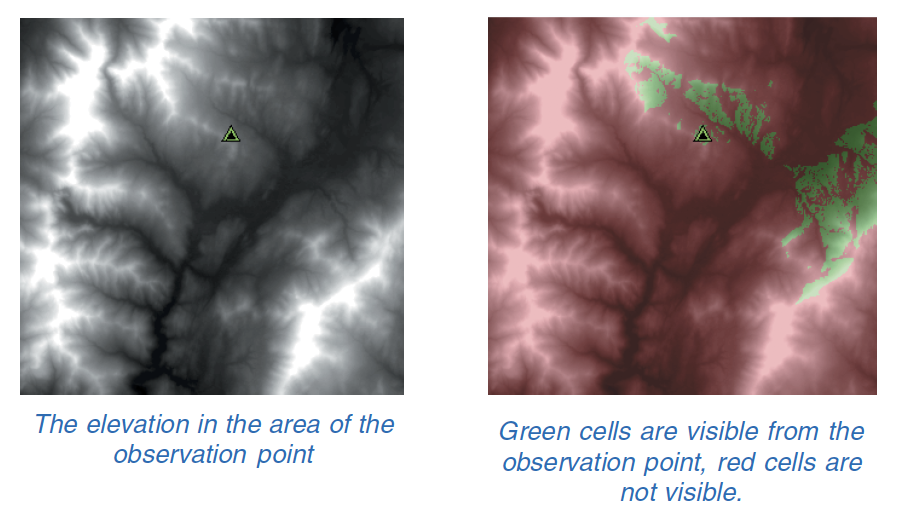</center>
<center>Figure 1. An example of creating viewshed with a single observation point</center>

In order to create viewshed, we need an input surface raster layer and an observer feature layer. In this example, we will use an elevation layer as the input raster and a few points representing schools as the observer layer.

In [3]:
items1 = gis.content.search("title: elevation, owner:portaladmin", item_type="Imagery Layer")
items1[0]

<Item title:"elevation" type:Imagery Layer owner:portaladmin>

In [4]:
input_raster = items1[0].layers[0] # elevation/DEM raster layer

In [ ]:
map1 = gis.map('Stowe, Vermont, USA')
map1

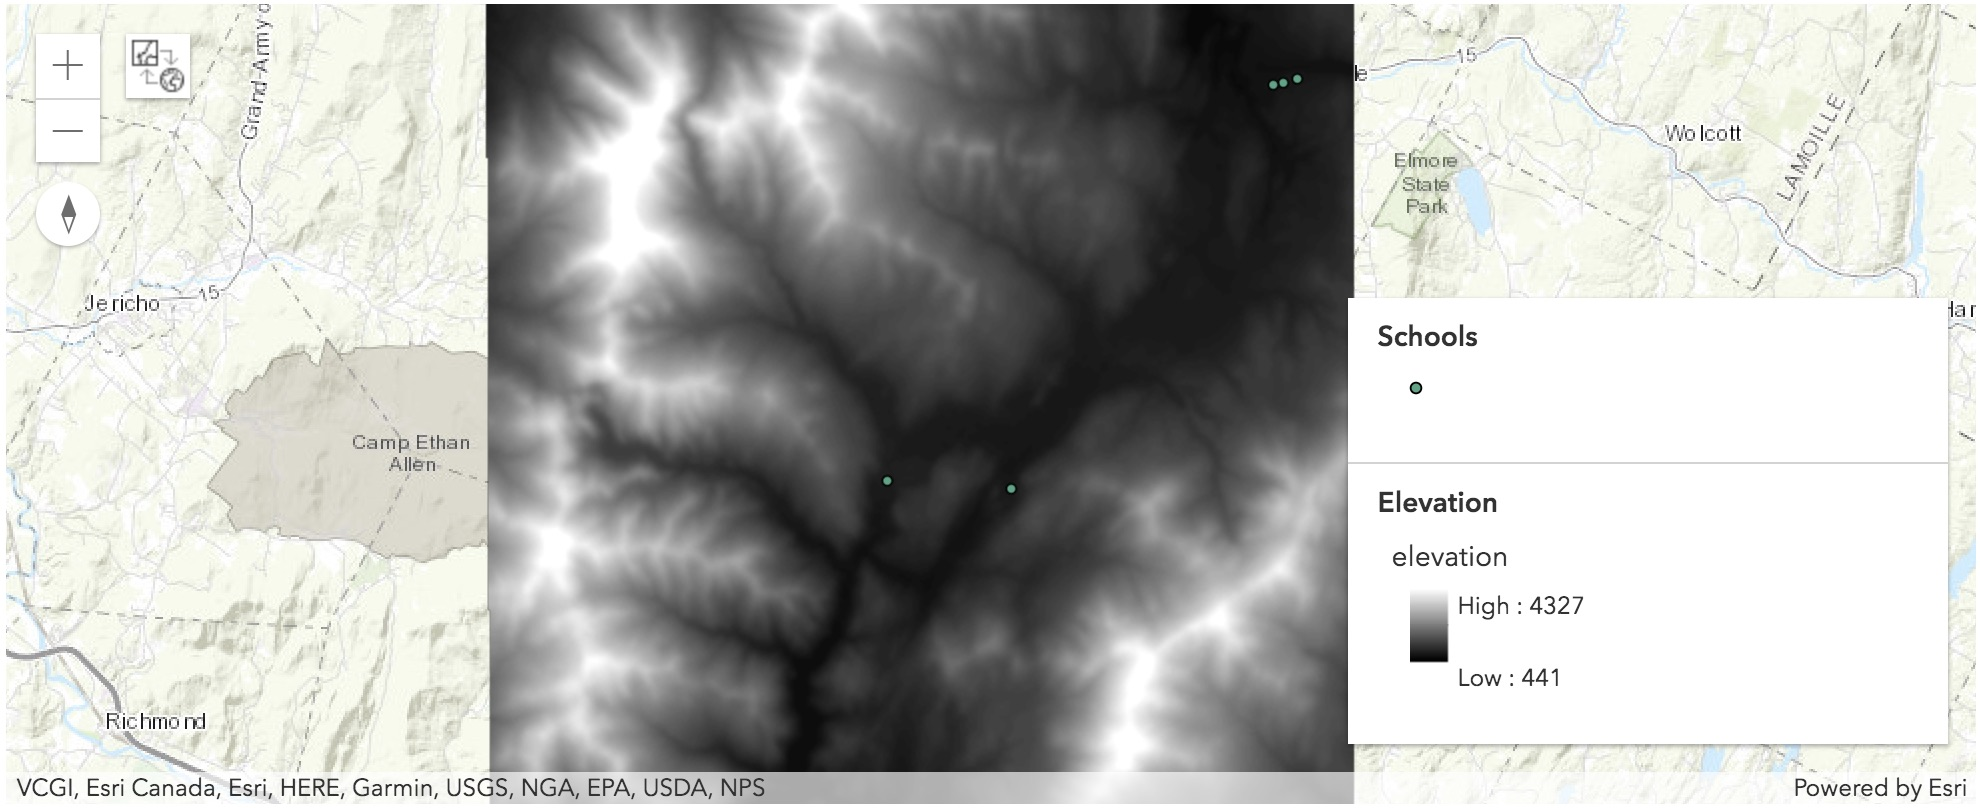

In [6]:
map1.add_layer(input_raster)

In [10]:
map1.legend = True

<Item title:"schools" type:Feature Layer Collection owner:portaladmin>
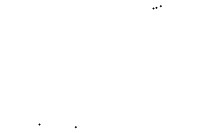

In [7]:
items2 = gis.content.search("title: schools, owner:portaladmin", item_type="Feature Layer")
items2[0]

In [8]:
observer_layer = items2[0].layers[0] # school points as observer layer
map1.add_layer(observer_layer)

As you can see, we have added five schools on the map.
Now we have the input layers in place, we are ready to create viewshed.

In [9]:
from arcgis.raster.analytics import create_viewshed

res = create_viewshed(input_elevation_surface = input_raster,
                      input_observer_features= observer_layer)
res

<Item title:"CreateViewshed_CGU80D" type:Imagery Layer owner:portaladmin>

Let's visualize the viewshed output.

In [ ]:
map2 = gis.map('Stowe, Vermont, USA')
map2

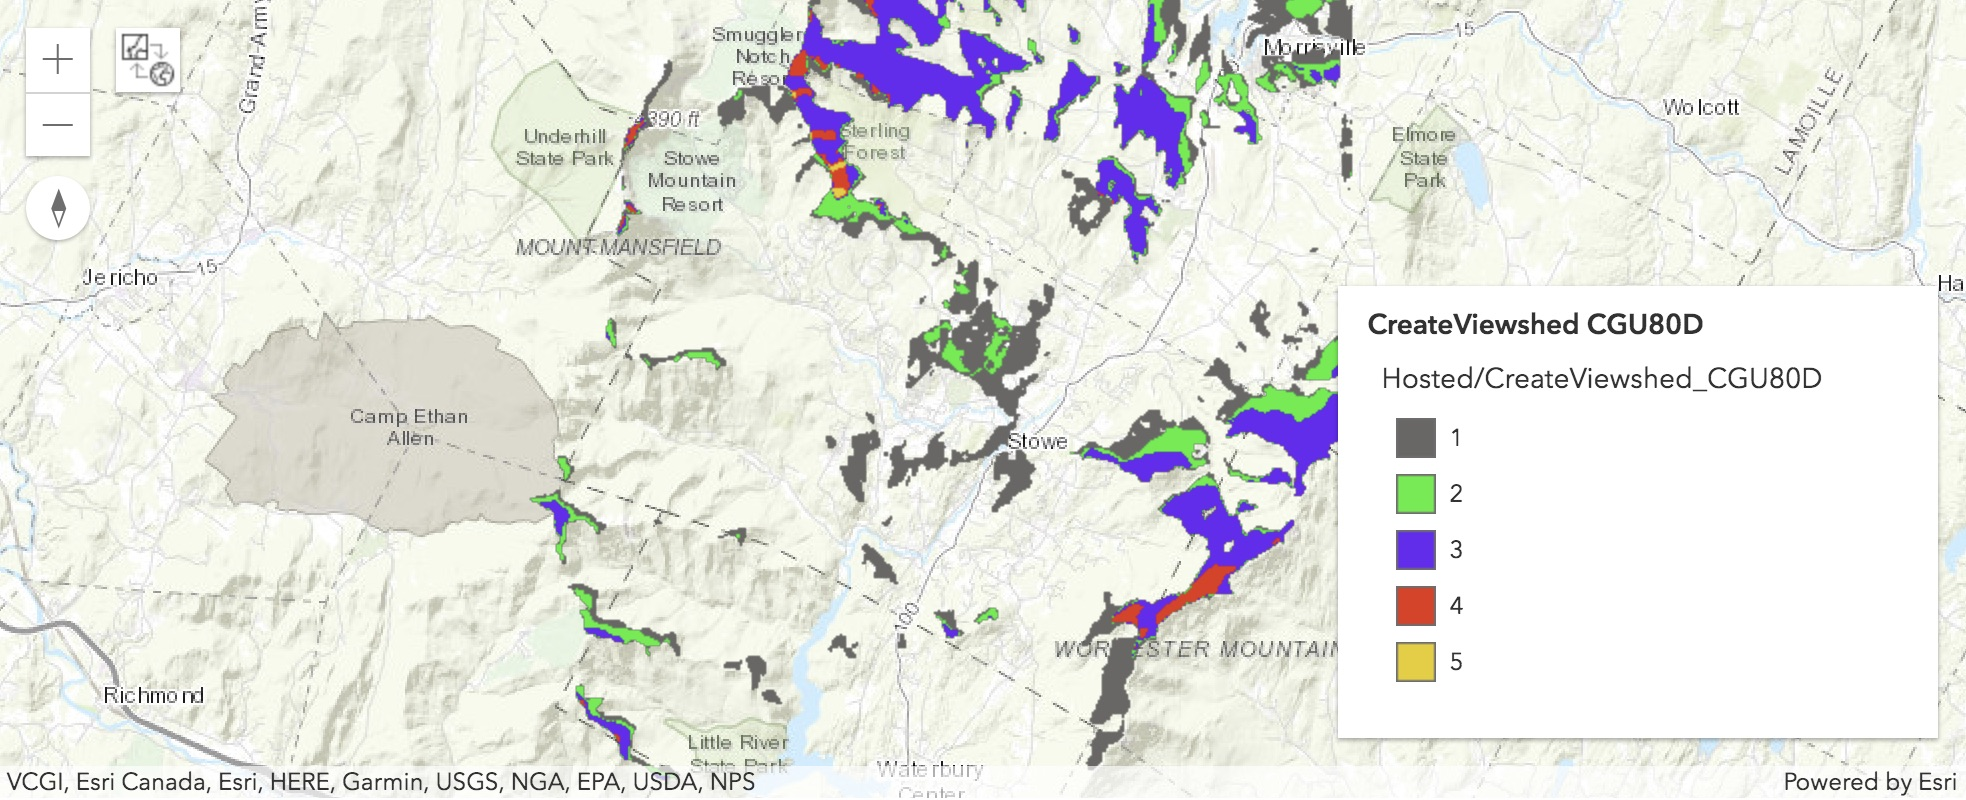

In [31]:
map2.add_layer(res)

Let's enable the legend to make more sense of the viewshed result.

In [32]:
map2.legend = True

As we can see, there are five different colors, each representing a number. For example, red pixels means four schools can been seen from them.

## Interpolating points

Interpolation predicts values for cells in a raster from a limited number of sample data points. It can be used to predict unknown values for any geographic point data, such as elevation, rainfall, chemical concentrations, and noise levels.

<center>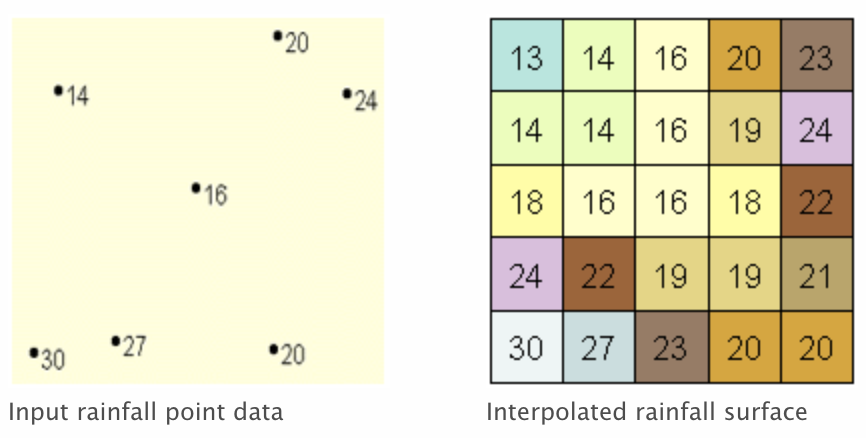</center>
<center>Figure 2. An example of interpolating rainfall point data</center>

The interpolation tools are generally divided into deterministic and geostatistical methods. The deterministic interpolation methods assign values to locations based on the surrounding measured values and on specified mathematical formulas that determine the smoothness of the resulting surface. The deterministic methods include IDW (inverse distance weighting), Natural Neighbor, Trend, and Spline.

The geostatistical methods are based on statistical models that include autocorrelation (the statistical relationship among the measured points). Because of this, geostatistical techniques not only have the capability of producing a prediction surface but also provide some measure of the certainty or accuracy of the predictions. Ordinary Kriging and Empirical Bayesian Kriging are geostatistical methods of interpolation.

In this example, we use ozone concentration point samples (measurements) in California to produce a continuous surface (map) predicting the values of ozone concentration for every location throughtout the state.

<Item title:"O3_Sep06_3pm" type:Feature Layer Collection owner:portaladmin>
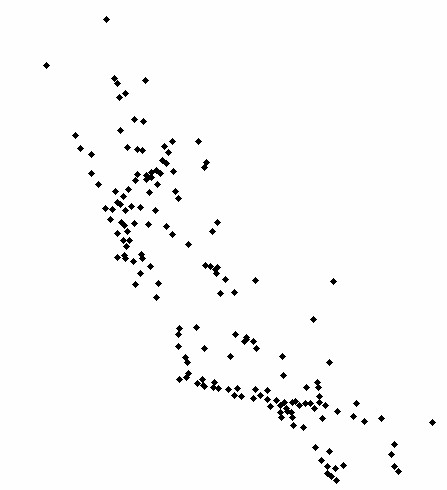

In [34]:
items3 = gis.content.search("title: O3_Sep06_3pm, owner:portaladmin", item_type="Feature Layer")
items3[0]

In [35]:
ozone_layer = items3[0].layers[0]

Now we have the ozone point samples, we are ready to interpolate these points to create a continuous surface. By default, `interpolate_points()` uses [Empirical Bayesian kriging](https://pro.arcgis.com/en/pro-app/help/analysis/geostatistical-analyst/what-is-empirical-bayesian-kriging-.htm) under the hood.

In [36]:
from arcgis.raster.analytics import interpolate_points

res = interpolate_points(input_point_features = ozone_layer,
                         interpolate_field = "OZONE",
                         output_name = "interpolation_res1")
res

FunctionOutput(output_raster=<Item title:"interpolation_res1" type:Imagery Layer owner:portaladmin>, process_info=<IPython.core.display.HTML object>)

`interpolate_points()` can generate multiple raster outputs based on output_prediction_error parameter and hence it returns a named tuple that contains:
- output_raster (the output_raster item description is updated with the process_info),
- process_info (if run in a non-Jupyter environment, use process_info.data to get the HTML data) and 
- output_error_raster (if output_prediction_error is set to True).   

In [37]:
res.output_raster # access the result item through the `output_raster` property

<Item title:"interpolation_res1" type:Imagery Layer owner:portaladmin>

In [ ]:
map3 = gis.map('California, USA')
map3

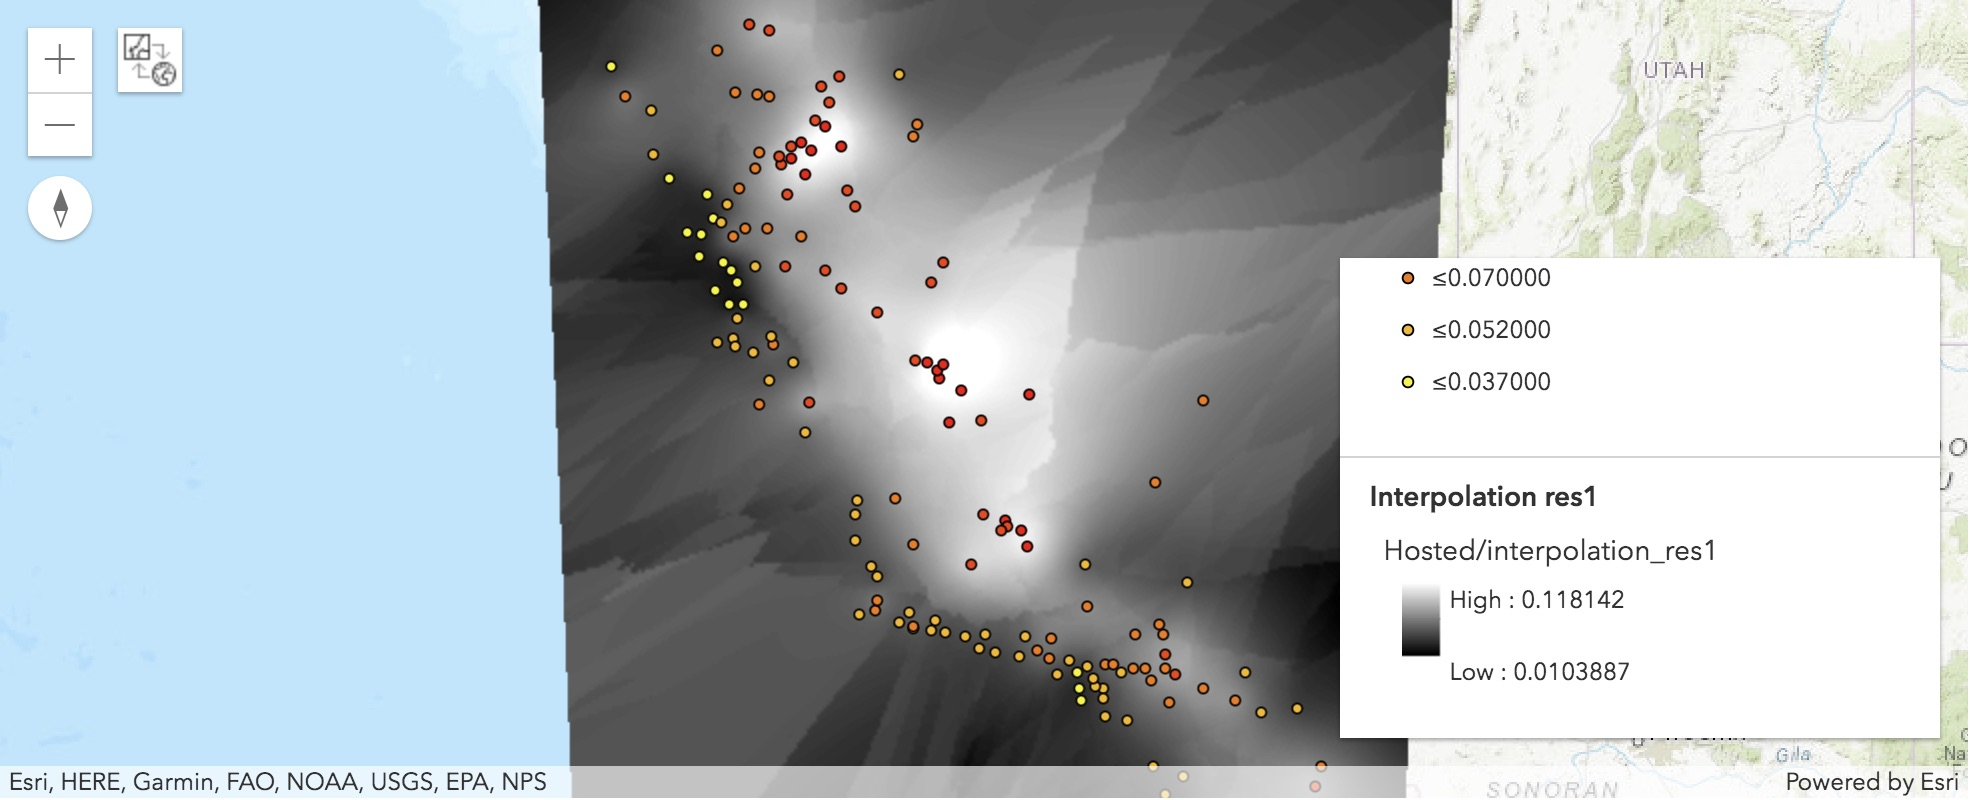

In [39]:
map3.add_layer(res.output_raster)
map3.add_layer(ozone_layer)

In [40]:
map3.legend = True

## Converting feature to raster

You can convert any feature class (polygon, polyline, or point) to a raster with `convert_feature_to_raster()`. When you convert points, cells are usually given the value of the points found within each cell. Cells that do not contain a point are given the value of NoData. If more than one point is found in a cell, the cell is given the value of the first point it encounters when processing. Using a smaller cell size during conversion may alleviate this. More information can be found at [here](http://desktop.arcgis.com/en/arcmap/10.3/tools/conversion-toolbox/converting-features-to-raster-data.htm).

In this guide, we are going to take the same ozone data from the example above and convert it into a raster layer. `value_field` is the field that will be used to assign values to the output raster.

In [64]:
from arcgis.raster.analytics import convert_feature_to_raster

res = convert_feature_to_raster(input_feature = ozone_layer,
                                value_field = "OZONE",
                                output_cell_size = {"distance":3000,"units": "meters"})
res

<Item title:"ConvertFeatureToRaster_BT5DP0" type:Imagery Layer owner:portaladmin>

As you can see, the returned item is an `Imagery Layer`. Now let's add it onto a map.


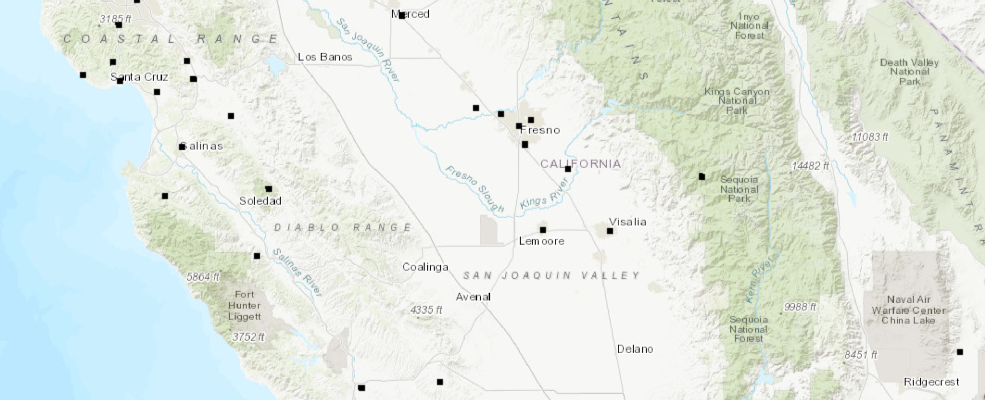

In [67]:
map4 = gis.map('California, USA')
map4

In [68]:
map4.add_layer(res)
raster_layer = res.layers[0]

As we can see, cells that do not contain a point are given the value of NoData, which are transparent.

## Converting raster to feature

In the meanwhile, we can convert raster data to feature class as well. `convert_raster_to_feature()` supports all polygon, polyline, and point data.
Let's take the result from the last step - `raster_layer` and convert it back into a feature class.

In [69]:
from arcgis.raster.analytics import convert_raster_to_feature

res = convert_raster_to_feature(input_raster = raster_layer,
                                output_type = "Point")
res

<Item title:"RasterToFeature_9BA39C" type:Feature Layer Collection owner:portaladmin>

Let's load the result into a spatially enabled dataframe.

In [72]:
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor

sdf = pd.DataFrame.spatial.from_layer(res.layers[0])
len(sdf)

167

We can also dive into the attributes of these 167 points.

In [73]:
sdf.head()

,SHAPE,grid_code,objectid,pointid
0,"{""x"": -220664.8320000004, ""y"": 415180.40939999...",0.0430,1,1
1,"{""x"": -352664.8320000004, ""y"": 313180.40940000...",0.0210,2,2
2,"{""x"": -202664.8320000004, ""y"": 283180.40939999...",0.0394,3,3
3,"{""x"": -133664.83199999854, ""y"": 280180.4093999...",0.0500,4,4
4,"{""x"": -193664.8320000004, ""y"": 274180.40939999...",0.0450,5,5


As can be seen, we have got 167 points with different geographic coordinates. Notice that we have a `grid_code` column that represents the cell value when the data was in raster form.

In this guide, we have demonstrated how to create viewshed, interpolate points, convert raster to feature, and convert feature to raster, but these are just a few examples. There are many other out-of-the-box tools available and can be found at [API reference](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.toc.html#submodules).